# Analysis of Airbnb Data for Munich Octoberfest


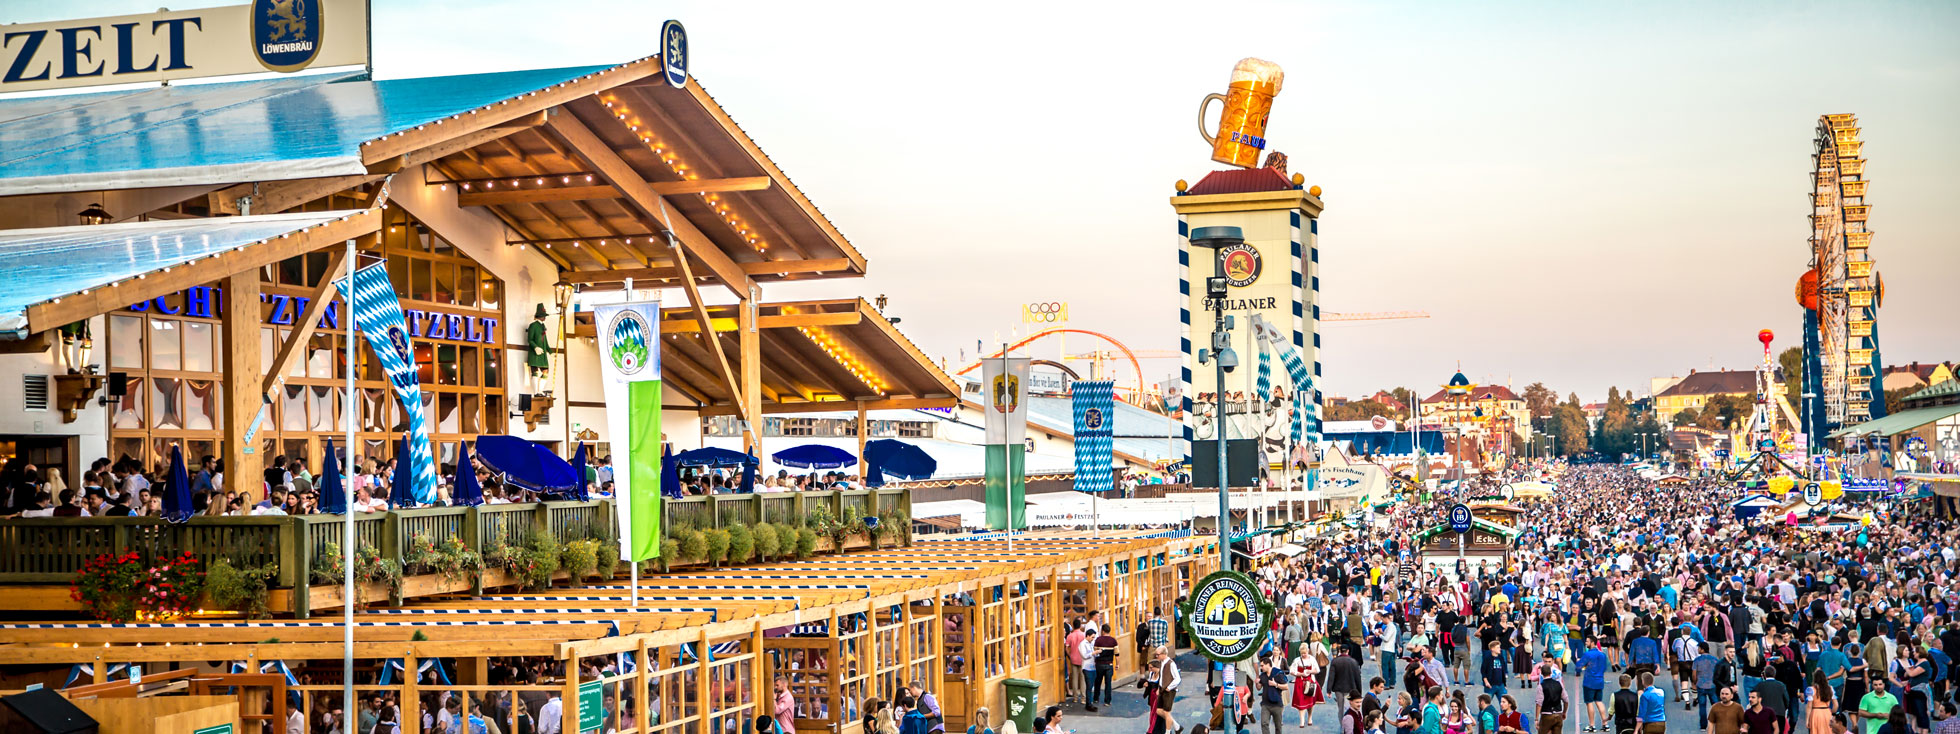

**Motivation:** I am still trying to understand a bit more about the current real estate market in munich, especially the area around the octoberfest (theresienwiese). Therefore I think the Airbnb dataset for munich could be one possible source of information to gain usefull insights in the current situation.

**Dataset:** The used data sets were created on November 25th, 2019 and contain detailed listings data, review data and calendar data of current Airbnb listings in Munich, Germany. This data was created by Murray Cox and his Inside Airbnb project which can be found here:  http://insideairbnb.com/get-the-data.html

The data set can also be found here: https://www.kaggle.com/chriskue/munich-airbnb-data

**Methodology:** For the analysis I will use the *CRISP-DM* Methodology. CRIPS-DM stands for "cross-industry process for data mining". The process consists of six steps:

1. Business Understanding
1. Data Understanding
1. Data Preparation
1. Modeling
1. Evaluation
1. Deployment

The underlying Jupyter notebook can be found on Github (https://github.com/noema-git/airbnb-analysis)

# 1. Business Understanding

**Airbnb background information:**
Airbnb is a community-based platform that supports magical travel that is local, authentic and unique. Airbnb has more than 5 million listings and operates in 191 countries and more than 81,000 cities. To date, the Airbnb community has hosted nearly half-a-billion guests through a model designed to support healthy travel.

**Specific questions to answer:**
1. What are the TOP 3 most expensive city districts for a stay in Munich in general?
2. What are the TOP 5 city districts in munich with the best distance-price-ratio for a stay near the are of the octoberfest?
3. What are the TOP 3 factors influence the price for a stay near the area of the octoberfest?

In [ ]:
# Import all the libraries which will be needed later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

%matplotlib inline

# 2. Data Understanding

## 2.1. Load the relevant dataset  
The available csv data sets from Inside Airbnb (http://insideairbnb.com/munich/) was stored in a separately dataset (https://www.kaggle.com/chriskue/munich-airbnb-data) for further analysis.

The data set contains the following files:
*     **listings.csv**:  descriptions and review score
*     **calendar.csv**:  listing id, price and availability for the upcoming year
*     **reviews.csv**:   unique id for each reviewer and detailed comments

In [ ]:
df_listings = pd.read_csv("../input/munich-airbnb-data/listings.csv");
df_calendar = pd.read_csv("../input/munich-airbnb-data/calendar.csv");
df_reviews = pd.read_csv("../input/munich-airbnb-data/reviews.csv");

## 2.2. Understand the underlaying data
To get a better understanding of the data we will look at the features and the overall quality of the data ( e.g. missing values).

### 2.2.1. Dataset "calendar.csv"

In [ ]:
# Take a look at a concise summary of the DataFrame 'calendar'
df_calendar.info()

In [ ]:
# Show the first rows of the dataframe
df_calendar.head()

In [ ]:
# List all features in this data set and show the number of missing values
obj = df_calendar.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_calendar['listing_id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

In [ ]:
# Show the shape of the dataframe
df_calendar.shape

**Insights after analysing the dataset "calendar"**  

The data set consists of 7 features and a total rows of 4.190.565.

The overall quality is good, only the features 'price' and 'adjusted_price' have missing data (both 171).

For further analysis the following data cleaning is recommended:
- Drop feature 'adjusted_price'.
- Remove the rows with missing data in 'price' (number of affected rows is low ~0.004%).
- The feature 'price' needs to be converted to numerical value
- The feature 'date' needs to be converted to datetime format
- The feature 'available' needs to be converted into bool data type

### 2.2.2. Dataset "listing.csv"

In [ ]:
# Take a closer look at a concise summary of the DataFrame 'listings'
df_listings.info()

In [ ]:
# Show the first rows of the dataframe
df_listings.iloc[:,100:120].head()

In [ ]:
# List all features in this data set and show the number of missing values
obj = df_listings.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_listings['id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

In [ ]:
# Show distinct observations per feature and absolute frequency
df_listings["zipcode"].value_counts()

In [ ]:
# Show the shape of the dataframe
df_listings.shape

In [ ]:
# Count distinct observations per feature
df_listings.nunique()

**Insights after analysing the dataset "listings"**  

The dataset consists of 106 features and a total rows of 11.481.  

The overall quality is not for all features good. It must be considered how to deal with the remaining missing values. 

Filling does not look very promising in all cases, so the features should be droped from a threshold.

Some features have only constant values and don't help us any further.

For further analysis the following data cleaning is recommended:  
- Drop features with constant values 
- Drop features with more than 50% missing data
- Fill missing numerical data with mean value
- Convert features to useable data type (e.g. price)
- Drop features that do not provide us with any useful information (for our specific questions) 

### 2.2.3 Dataet "reviews.csv"


In [ ]:
# Take a look at a concise summary of the DataFrame 'reviews'
df_reviews.info()

In [ ]:
# Show the first rows of the dataframe
df_reviews.head()

In [ ]:
# List all features in this data set and show the number of missing values
obj = df_reviews.isnull().sum()
for key,value in obj.iteritems():
    percent = round((value * 100 / df_reviews['id'].index.size),3)
    print(key,", ",value, "(", percent ,"%)")

In [ ]:
# Show the shape of the dataframe
df_reviews.shape

**Insights after analysing the dataset "reviews"**  

The dataset consists of 6 features and a total of 175.562 rows.   

The overall quality is good, only the feature 'comments' has missing data (74).  

At first sight the data set cannot be used to answer the questions. Nevertheless, the number of reviews shows an interesting pattern which should also be examined. 

Maybe the feature 'id' can be connected to the other data sets 'calendar' or 'listings'. 

If I used the data set for my further analysis, I would drop missing data in 'comments' (number of affected rows is low ~0.04%) and convert the feature 'date' in to the 'DateTime' data type.

# 3. Data Preparation

## 3.1 Final feature selection 
Select final features necessary to answer our three defined questions. 

Finally we only need some specific and meaningfulls features to answer our business questions. 

The features can be devided in five sections:
- Location
- Room
- Price
- Score

To answer this question we use following sections and thier assoziated features:

**Location:**
- neighbourhood_cleansed
- zipcode
- latitude
- longitude

**Room:**
- room_type = Zimmer oder Apartment
- square_feet = Größe in QM
- minimum_nights	
- maximum_nights
- bathroome

**Price:**
- price	
- weekly_price	
- monthly_price	
- security_deposit(...)	
- cleaning_fee	
- guests_included	
- extra_people	

**Score:**
- number_of_reviews
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value 
- reviews_per_month

## 3.2 Question 1: "What are the TOP 3 most expensive city districts for a stay in Munich in general?"

### 3.2.1 Additional information for munich districts
To better understand how munich is structured, we take a closer look at the specific districts in munich. The information and images provided can be found at wikipedia (https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens).

### 3.2.1.1 Area = Stadtbezirke


### 3.2.1.2 Section = Stadtbezirksteile


### 3.2.1.3 Section = Postleitzahlen

In [ ]:
# Copy the data to a new DataFrame for further clean up
df_listings_clean = df_listings.copy(deep=True)

In [ ]:
# Clean up the data set "listings" as the previous analysis pointed out

# Drop features which are not used further 
features_to_drop = ['listing_url', 'picture_url','host_url', 'host_thumbnail_url', 'host_picture_url',
                    'name', 'summary', 'space', 'neighborhood_overview', 'transit', 'interaction', 'description',
                    'host_name', 'host_location', 'host_neighbourhood', 'street', 'last_scraped',
                    'calendar_last_scraped', 'first_review', 'last_review', 'host_since', 'calendar_updated',
                    'experiences_offered', 'state', 'country', 'country_code', 'city', 'market',
                    'host_total_listings_count', 'smart_location']
df_listings_clean.drop(features_to_drop, axis=1, inplace=True)

In [ ]:
# Remove constant features by finding unique values per feature 
df_listings_clean = df_listings_clean[df_listings_clean.nunique().where(df_listings_clean.nunique()!=1).dropna().keys()]

# Drop features with 50% or more missing values
more_than_50 = list(df_listings_clean.columns[df_listings_clean.isnull().mean() > 0.5])
df_listings_clean.drop(more_than_50, axis=1, inplace=True)

# Clean up the format values. Maybe not the best solution - but will do the job.
df_listings_clean['price'] = df_listings_clean['price'].replace('[\$,]', '', regex=True).astype(float)
df_listings_clean['extra_people'] = df_listings_clean['extra_people'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_listings_clean['cleaning_fee'] = df_listings_clean['cleaning_fee'].replace({'\$': '', ',': ''}, regex=True).astype(float)
        
# Convert rates type from string to float and remove the % sign
df_listings_clean['host_response_rate'] = df_listings_clean['host_response_rate'].str.replace('%', '').astype(float)
df_listings_clean['host_response_rate'] = df_listings_clean['host_response_rate'] * 0.01
    
# Covert boolean data from string data type to boolean
boolean_features = ['instant_bookable', 'require_guest_profile_picture', 
                'require_guest_phone_verification', 'is_location_exact', 'host_is_superhost', 'host_has_profile_pic', 
                'host_identity_verified']
df_listings_clean[boolean_features] = df_listings_clean[boolean_features].replace({'t': True, 'f': False})

## Fill numerical missing data with mean value
numerical_feature = df_listings_clean.select_dtypes(np.number)
numerical_columns = numerical_feature.columns

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean = imp_mean.fit(numerical_feature)

df_listings_clean[numerical_columns] = imp_mean.transform(df_listings_clean[numerical_columns])
     
# Remove all remaining missing values  
df_listings_clean.dropna(inplace=True)

In [ ]:
# Show mean price for each neighbourhood_cleansed
df_listings_clean.groupby(["neighbourhood_cleansed"])["price"].describe().sort_values("mean", ascending=False)

In [ ]:
# Create new feature 'mean' with the mean price per neighbourhood
df_listings_clean['mean'] = df_listings_clean.groupby('neighbourhood_cleansed')['price'].transform(lambda r : r.mean())

In [ ]:
# Create plot for mean price per neighbourhood 
df_listings_plot = df_listings_clean
df_listings_plot = df_listings_plot.groupby('neighbourhood_cleansed')[['price']].mean()
df_listings_plot = df_listings_plot.reset_index()
df_listings_plot = df_listings_plot.sort_values(by='price',ascending=False)
df_listings_plot.plot.bar(x='neighbourhood_cleansed', y='price', color='blue', rot=90, figsize = (20,10)).set_title('Mean Price per city district (Neighbourhood)');

In [ ]:
# Since we also have the geo data (latitude and longitude) of the apartments we can create a map
fig = px.scatter_mapbox(df_listings_clean, color="mean", lat='latitude', lon='longitude',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10,
                        mapbox_style="open-street-map",width=1000, height=800);
fig.show()

### Summary for Question 1: "What are the TOP 3 most expensive city districts for a stay in Munich in general?"

From the analysis, there is a clear difference in the costs between the different neighbourhoods in Munich.   

In general - the closer the apartment is to the city center of Munich, the higher the price.

**Answer:**  
The TOP 3 expensive districts in Munich (on average price) are   
- Altstadt-Lehel 
- Trudering-Riem
- Allach-Untermenzing

## 3.3 Question 2: "What are the TOP 5 city districts in munich with the best distance-price-ratio for a stay near the are of the octoberfest?"

In [ ]:
# Create bins for mean price
bins = [0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400]
df_listings_clean['binned'] = pd.cut(df_listings_clean['mean'], bins)
df_listings_clean

In [ ]:
df_listings_clean["latitude"].describe()

In [ ]:
df_listings_clean["longitude"].describe()

In [ ]:
# Create squares for langitude and latitude
step = 0.0025
to_bin = lambda x: np.floor(x / step) * step
df_listings_clean["latbin"] = df_listings_clean.latitude.map(to_bin)
df_listings_clean["longbin"] = df_listings_clean.longitude.map(to_bin)
#groups = df_listings_clean.groupby(("latbin", "longbin"))

In [ ]:
# Create df_squares
df_squares = df_listings_clean[['neighbourhood_cleansed','zipcode','latitude','longitude','latbin','longbin','mean']]
df_squares

In [ ]:
# Show creates squares on map
fig = px.scatter_mapbox(df_listings_clean, color="mean", lat='latbin', lon='longbin',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10, 
                        mapbox_style="open-street-map",width=1000, height=800);
fig.show()

### 3.3.1 Octoberfest, Munich, Bavaria, Germany Geographic Information
- Latitude = 48.131
- Longitude = 11.550

In [ ]:
# Create dataset with octoberfest coordinates  
oct_data = {
        'id': ['Octoberfest',],
        'latitude': ['48.131'],
        'longitude': ['11.550']}
df_oct = pd.DataFrame(oct_data, columns = ['id', 'latitude', 'longitude'])
df_oct

In [ ]:
# Show place where octoberfest is located    
fig = px.scatter_mapbox(df_oct, lat='latitude', lon='longitude',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10,
                        mapbox_style="open-street-map",width=1000, height=800);
fig.show()

In [ ]:
### Getting distance between two points based on latitude/longitude
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

# places
lat_oct = radians(48.131)
lon_oct = radians(11.550)
lat_room = radians(48.14)
lon_room = radians(11.58)

dlon = lon_room - lon_oct
dlat = lat_room - lat_oct

a = sin(dlat / 2)**2 + cos(lat_oct) * cos(lat_room) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c * 1000
distance = round(distance, 2)

print("Result:", distance,"meters")

In [ ]:
# create copy
df_squares_oct = df_squares.copy()
df_squares_oct

In [ ]:
### Getting distance between two points based on latitude/longitude
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

# insert octoberfest coordinates and 
df_squares_oct['lat_oct'] = 48.131
df_squares_oct['long_oct'] = 11.550

# convert to radians
df_squares_oct['latbin_rad'] = np.radians(df_squares_oct['latbin'])
df_squares_oct['longbin_rad'] = np.radians(df_squares_oct['longbin'])
df_squares_oct['lat_oct_rad'] = np.radians(df_squares_oct['lat_oct'])
df_squares_oct['long_oct_rad'] = np.radians(df_squares_oct['long_oct'])

df_squares_oct['dlon'] = df_squares_oct['longbin_rad'] - df_squares_oct['long_oct_rad']
df_squares_oct['dlat'] = df_squares_oct['latbin_rad'] - df_squares_oct['lat_oct_rad']

df_squares_oct['a']  = np.sin(df_squares_oct['dlat'] / 2)**2 + np.cos(df_squares_oct['lat_oct_rad']) * np.cos(df_squares_oct['latbin_rad']) * np.sin(df_squares_oct['dlon'] / 2)**2

df_squares_oct['c'] = 2 * np.arctan2(np.sqrt(df_squares_oct['a']), np.sqrt(1 - df_squares_oct['a']))

df_squares_oct['distance_meter'] = R * df_squares_oct['c'] * 1000
df_squares_oct['distance_meter'] = round(df_squares_oct['distance_meter'], 2)

df_squares_oct

In [ ]:
# Show mean price for apartments
fig = px.scatter_mapbox(df_squares_oct, color="mean", lat='latbin', lon='longbin',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10, 
                        mapbox_style="open-street-map",width=1000, height=800);
fig.show()

# Show distance to octoberfest
fig = px.scatter_mapbox(df_squares_oct, color="distance_meter", lat='latbin', lon='longbin',
                        center=dict(lat=48.137154, lon=11.576124), zoom=10, 
                        mapbox_style="open-street-map",width=1000, height=800);
fig.show()

In [ ]:
# analyze distance
df_squares_oct['distance_meter'].describe()

In [ ]:
# bincount distance using linspace
y = np.linspace(0, 14000, 29) # 500 meter sections
df_squares_oct['distance_bins'] = pd.cut(df_squares_oct['distance_meter'], bins=y)
df_squares_oct

In [ ]:
# Analyze price
df_squares_oct['mean'].describe()

In [ ]:
# Bincount price using linspace
x = np.linspace(80, 170, 19) # 5 euro sections
df_squares_oct['mean_bins'] = pd.cut(df_squares_oct['mean'], bins=x)
df_squares_oct

In [ ]:
### Offline-Quoten: 2cat/1num
# Create heatmap
cat_var_1 = "neighbourhood_cleansed"
cat_var_2 = "distance_bins"
num_var_1 = "mean"

# Create heatmap
plt.figure(figsize=(30, 15))
cat_means = df_squares_oct.groupby([cat_var_1, cat_var_2]).mean()[num_var_1]
cat_means = cat_means.reset_index(name = 'avg')
cat_means = cat_means.pivot(index = cat_var_2, columns = cat_var_1,
                            values = 'avg')
sns.heatmap(cat_means, annot = True, fmt = '.4f', cmap="coolwarm",
           cbar_kws = {'label' : 'mean(avg)'})

plt.title("Fig.A: Compare distance to octoberfest in meters, average price for a room according to different districts", 
          fontsize=12, loc='center', pad=10)

In [ ]:
# Relative Häufigkeit von Offline-Nacharbeiten i.A. des Modells
plt.figure(figsize=(20, 10))
sns.lineplot(x="distance_meter", y="mean", data=df_squares_oct, err_style=None)
plt.title("Fig.B: Compare distance to octoberfest and average price for a room", fontsize=12, loc='center', pad=10)

In [ ]:
# Relative Häufigkeit von Offline-Nacharbeiten i.A. des Modells
plt.figure(figsize=(20, 15))
sns.lineplot(x="distance_meter", y="mean", hue="neighbourhood_cleansed", data=df_squares_oct, err_style=None)
plt.title("Fig.C: Compare distance to octoberfest and average price for a room with regards to district", fontsize=12, loc='center', pad=10)

### Summary for Question 2: "What are the TOP 5 city districts in munich with the best distance-price-ratio for a stay near the area of the octoberfest?"

As we can see in Fig.A and in Fig.C there is a clear winner in terms of the prefect distance-price-ratio, which is the "Sendling"-district with an average distance of round about 2000 meters and an average price of 103 euros. 
Fig.B shows that the average price tend to become smaller in general, but for some places it is also possible to pay a cheap price for a distance under 2000 meteres

**Answer:**  
The TOP 5 locations (district) with the best price-distance-ration are:  
- Sendling
- Sendling-Westpark
- Untergießing-Harlaching
- Laim
- Neuhausen-Nymphenburg

# 4. Modeling

## 4.1 Question 3: "What are the TOP 3 factors influence the price for a stay near the area of the octoberfest?"

To analyze question 3 we filter our dataset to the TOP 5 city districts in terms of the best possible distance-price-ratio (findings in question 3). For these TOP 5 location we wanna figure out, what factors most influence the pricing for our TOP city ditricts.

In [ ]:
# Copy the data to a new DataFrame for encoding 
df_listings_encoded = df_listings_clean.copy(deep=True)

In [ ]:
df_listings_encoded

In [ ]:
# Filter dataframe according to TOP 5 city districts in munich in terms of distance-price-ratio 
filter = ['Sendling','Sendling-Westpark','Untergiesing-Harlaching','Laim','Neuhausen-Nymphenburg']
df_listings_encoded = df_listings_encoded[df_listings_encoded.neighbourhood_cleansed.isin(filter)]
df_listings_encoded

In [ ]:
# control filter activities, correct!
df_listings_encoded.neighbourhood_cleansed.unique()

In [ ]:
# Shape of dataset
df_listings_encoded.shape

In [ ]:
# Encode features for use in machine learing model

# Encode feature 'amenities' and concat the data
df_listings_encoded.amenities = df_listings_encoded.amenities.str.replace('[{""}]', "")
df_amenities = df_listings_encoded.amenities.str.get_dummies(sep = ",")
df_listings_encoded = pd.concat([df_listings_encoded, df_amenities], axis=1) 

# Encode feature 'host_verification' and concat the data
df_listings_encoded.host_verifications = df_listings_encoded.host_verifications.str.replace("['']", "")
df_verification = df_listings_encoded.host_verifications.str.get_dummies(sep = ",")
df_listings_encoded = pd.concat([df_listings_encoded, df_verification], axis=1)
    
# Encode feature 'host_response_time'
dict_response_time = {'within an hour': 1, 'within a few hours': 2, 'within a day': 3, 'a few days or more': 4}
df_listings_encoded['host_response_time'] = df_listings_encoded['host_response_time'].map(dict_response_time)

# Encode the remaining categorical feature 
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'neighbourhood', 
                            'cancellation_policy']:
    df_listings_encoded = pd.concat([df_listings_encoded, 
                                     pd.get_dummies(df_listings_encoded[categorical_feature])],axis=1)
        
# Drop features
df_listings_encoded.drop(['amenities', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 
                          'host_verifications', 'neighbourhood','cancellation_policy','security_deposit',
                          'id', 'host_id', 'mean', 'latitude', 'longitude'],
                         axis=1, inplace=True)

In [ ]:
# Last check if there are any missing values in the data set
sum(df_listings_encoded.isnull().sum())

In [ ]:
# Shuffle the data to ensure a good distribution
df_listings_encoded = shuffle(df_listings_encoded)

X = df_listings_encoded.drop(['price',"zipcode","binned"], axis=1)
y = df_listings_encoded['price']

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Control shape after train-test-split, correct!
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# Initalize the model
model = RandomForestRegressor(max_depth=15, n_estimators=100, criterion='mse', random_state=42)
model

In [ ]:
# Fit the model on training data
model.fit(X, y)

In [ ]:
# Predict results
prediction = model.predict(X_test)
prediction

# 5. Evaluation
For the evaluation we look at the coefficient of determination (r squared value) of the training set and the test set, so we can compare the quality of the model.

In [ ]:
# Evaluate the result - compare r squared of the training set with the test set

# Find R^2 on training set
print("Training Set:")
print("R_squared:", round(model.score(X_train, y_train) ,2))

# Find R^2 on testing set
print("\nTest Set:")
print("R_squared:", round(model.score(X_test, y_test), 2))

In [ ]:
# Scatter plot of th actual vs predicted data
plt.figure(figsize=(10, 10))
plt.grid()
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.plot([0,200],[0,200], color='#AAAAAA', linestyle='dashed')
plt.scatter(y_test, prediction, alpha=0.5)
coef = np.polyfit(y_test,prediction,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test, poly1d_fn(y_test))
plt.title('Actual vs. Predicted data');
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

In [ ]:
# Sort the importance of the features
importances = model.feature_importances_
    
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:10]
y_feature = np.arange(len(features))
score = feature_importances['score'][:10]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 10)');

### Summary for Question 3: "What are the TOP 3 factors influence the price for a stay near the area of the octoberfest?"

With a coefficient of determination (R^2 of 0.92 for our testset), the model and the prediction seems accurate enough to predict the price of an apartment. Moreover, the coefficient of determination of the training data is the same (R^2 of 0.90 for our training set) .

**Answer:**  
The TOP 3 factors of an apartment that have the greatest influence on the price are:
- Accommodates
- Bedrooms
- Extra people

# 6. Deployment

The deployment is the final phase of the CRISP-DM process.   

In this phase, the results obtained are processed in order to present them and feed them into the client's decision-making process. 

And in the last step of the CRISP-DM model, the results obtained are summarized, processed and presented in an understandable way

This blog post and the Repo on Github (https://github.com/noema-git/airbnb-analysis) is the deployment of this work. To improve the quality of the model the CRSIP-DM cycle should be with adjusted parameters run through again.

![https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/240px-CRISP-DM_Process_Diagram.png](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/240px-CRISP-DM_Process_Diagram.png)

# Summary

This notebook uses data from the Munich, Germany area of Airbnb and has been analyzed to answer the following questions. 

### Question 1: "What are the TOP 3 most expensive city districts for a stay in Munich in general?"  
**Answer:**  
The TOP 3 expensive districts in Munich (on average price) are   
- Altstadt-Lehel 
- Trudering-Riem
- Allach-Untermenzing

### Question 2: "What are the TOP 5 city districts in munich with the best distance-price-ratio for a stay near the area of the octoberfest?" 
**Answer:**   
The TOP 5 locations (district) with the best price-distance-ration are:  
- Sendling
- Sendling-Westpark
- Untergießing-Harlaching
- Laim
- Neuhausen-Nymphenburg

### Question 3: "What are the TOP 3 factors influence the price for a stay near the area of the octoberfest?"
**Answer:**
The TOP 3 factors of an apartment that have the greatest influence on the price are:
- Accommodates
- Bedrooms
- Extra people

This analysis was done as a project within the Udacity Data Science Nanodegree.   
Any kind of optimization is very welcome. I really appreciate any feedback to improvement.  

The underlying Jupyter Notebook to this evaluation can be found on GitHub (https://github.com/noema-git/airbnb-analysis)